In [14]:
#%% 
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import os

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

directory = os.fsencode("/Users/sydney/git/twitter-study/AnalysisSP/SecondOrderContactsPaper/DataBimodalFit")

#Comment: This notebook is based on/follows the structure of https://www.pymc.io/projects/examples/en/2021.11.0/mixture_models/gaussian_mixture_model.html

In [15]:
for file in os.listdir(directory):
    
    filename = "/Users/sydney/git/twitter-study/AnalysisSP/SecondOrderContactsPaper/DataBimodalFit/" + os.fsdecode(file)
    #filename = "/Users/sydney/git/twitter-study/AnalysisSP/SecondOrderContactsPaper/DataBimodalFit/" + "Leisure032020.csv"
    dataframe = pd.read_csv(
            filename, index_col = 0
    )
    data = dataframe["value"].to_xarray()
    lendata = len(dataframe.index)
    k = 1

    with pm.Model(coords={"cluster": range(k), "obs_id": np.arange(lendata)}) as model:
        μ = pm.Normal(
                    "μ",
                    mu=[-50],
                    sigma=1,
                    transform=pm.distributions.transforms.univariate_ordered,
                    #initval=[-45],
                    dims="cluster",
        )
        σ = pm.HalfNormal("σ", sigma=[0.2], dims="cluster")
        weights = pm.Dirichlet("weights", np.ones(k), dims="cluster")
        pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=data, dims = "obs_id")

        pm.model_to_graphviz(model)
    with model:
        trace = pm.sample(5000, n_init=1000, tune=5000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

            # sample posterior predictive samples
        ppc_trace = pm.sample_posterior_predictive(trace, var_names=["μ", "σ", "weights"])

    az.plot_trace(trace, var_names=["μ", "σ"]);
    xi = np.linspace(-100, 10, 500)
    post = trace.posterior
    summary = az.summary(post)
    outputfilename = os.fsdecode(file) + "posteriorunimodal" 
    summary.to_csv(outputfilename)
    pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["weights"]
    pdf = pdf_components.sum("cluster")

    fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
        # empirical histogram
    ax[0].hist(data, 200)
    ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
        # pdf
    pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
    ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
        # plot group membership probabilities
    (pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
    ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

    fig_name = os.fsdecode(file) + "unimodalOutput.png"
    #fig.suptitle("Leisure0320201", fontsize=16)
    #fig_name = "Leisure0320201Gaussian.png"
    fig.savefig(fig_name, bbox_inches="tight")
    
    k = 2

    with pm.Model(coords={"cluster": np.arange(k), "obs_id": np.arange(lendata)}) as model_2:
            #cluster sizes
        weights = pm.Dirichlet("weights", a=np.array([1.0, 0.5]), dims="cluster")
        #ensure all clusters have some points
        p_min_potential = pm.Potential("p_min_potential", pm.math.switch(pm.math.min(weights) < 0.1, -np.inf, 0))
            #cluster means
        μ = pm.Normal(
                "μ",
                mu=[-50,0],
                sigma=1,
                #transform=pm.distributions.transforms.univariate_ordered,
                #initval=[-100,0],
                dims="cluster",
        )
            #break symmetry 
        order_means_potential = pm.Potential(
                "order_means_potential",
                pm.math.switch(μ[1] - μ[0] < 0, -np.inf, 0)
        )
            #measurement error
        σ  = pm.Uniform("σ", lower=0, upper=20)
            
            #latent cluster of each observation
        category = pm.Categorical("category", p = weights, dims = "obs_id")
            
            #likelihood for each observed value
        points = pm.Normal("obs", mu=μ[category], sigma=σ, observed=data, dims="obs_id")
            #pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=data, dims = "obs_id")

    pm.model_to_graphviz(model)
    with model_2:
        step1 = pm.Metropolis(vars=[weights, μ, σ])
        step2 = pm.CategoricalGibbsMetropolis(vars=[category])
        trace2 = pm.sample(1000, step=[step1, step2], tune=1000, return_inferencedata=True,idata_kwargs={"log_likelihood": True})
            # sample posterior predictive samples
        ppc_trace_2 = pm.sample_posterior_predictive(trace2, var_names=["weights", "μ", "σ"])
            
    az.plot_trace(trace2, var_names=["μ", "weights", "σ"]);
    xi = np.linspace(-100, 10, 500)
    post = trace2.posterior
    summary = az.summary(post)
    outputfilename = os.fsdecode(file) + "posteriorbimodal"
    summary.to_csv(outputfilename)
    pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["weights"]
    pdf = pdf_components.sum("cluster")

    fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
    # empirical histogram
    ax[0].hist(data, 200)
    ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
    # pdf
    pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
    ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
    # plot group membership probabilities
    (pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
    ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

    fig_name = os.fsdecode(file) + "bimodalOutput.png"
    fig.savefig(fig_name, bbox_inches="tight")
    
    k = 3

    with pm.Model(coords={"cluster": np.arange(k), "obs_id": np.arange(lendata)}) as model_3:
            #cluster sizes
        weights = pm.Dirichlet("weights", a=np.array([0.5, 1.0, 0.5]), dims="cluster")
            #ensure all clusters have some points
        p_min_potential = pm.Potential("p_min_potential", pm.math.switch(pm.math.min(weights) < 0.1, -np.inf, 0))
            #cluster means
        μ = pm.Normal(
                "μ",
                mu=[-100,-50,0],
                sigma=1,
                #transform=pm.distributions.transforms.univariate_ordered,
                #initval=[-100,0],
                dims="cluster",
        )
            #break symmetry 
        order_means_potential = pm.Potential(
                "order_means_potential",
                pm.math.switch(μ[1] - μ[0] < 0, -np.inf, 0) + pm.math.switch(μ[2] - μ[1] < 0, -np.inf, 0)
        )
            #measurement error
        σ  = pm.Uniform("σ", lower=0, upper=20)
            
            #latent cluster of each observation
        category = pm.Categorical("category", p = weights, dims = "obs_id")
            
            #likelihood for each observed value
        points = pm.Normal("obs", mu=μ[category], sigma=σ, observed=data, dims="obs_id")
            #pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=data, dims = "obs_id")
    
    pm.model_to_graphviz(model)    
    
    with model_3:
        step1 = pm.Metropolis(vars=[weights, μ, σ])
        step2 = pm.CategoricalGibbsMetropolis(vars=[category])
        trace3 = pm.sample(1000, step=[step1, step2], tune=1000, return_inferencedata=True,idata_kwargs={"log_likelihood": True})
        # sample posterior predictive samples
        ppc_trace_4 = pm.sample_posterior_predictive(trace3, var_names=["weights", "μ", "σ"])
        az.plot_trace(trace3, var_names=["μ", "weights", "σ"]);
        xi = np.linspace(-100, 10, 500)
        post = trace3.posterior
        summary = az.summary(post)
        outputfilename =  os.fsdecode(file) + "posteriortrimodal"
        summary.to_csv(outputfilename)
        pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["weights"]
        pdf = pdf_components.sum("cluster")

        fig, ax = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
            # empirical histogram
        ax[0].hist(data, 200)
        ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
            # pdf
        pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
        ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
            # plot group membership probabilities
        (pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
        ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

        fig_name = os.fsdecode(file) + "trimodalOutput.png"
        fig.savefig(fig_name, bbox_inches="tight")

        df_comp_loo = az.compare({"one_dist": trace, "two_dist": trace2, "three_dist":trace3})
        outputfilename =  os.fsdecode(file) + "loo_comparison"
        df_comp_loo.to_csv(outputfilename)

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/distributions/transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, weights]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 4 seconds.
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [weights, μ, σ]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [weights]
>>Metropolis: [μ]
>>Metropolis: [σ]
>CategoricalGibbsMetropolis: [category]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:318: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/pymc/distributions/transforms.py:56: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, weights]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 3 seconds.
/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [weights, μ, σ]


/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/sydney/git/twitter-study/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


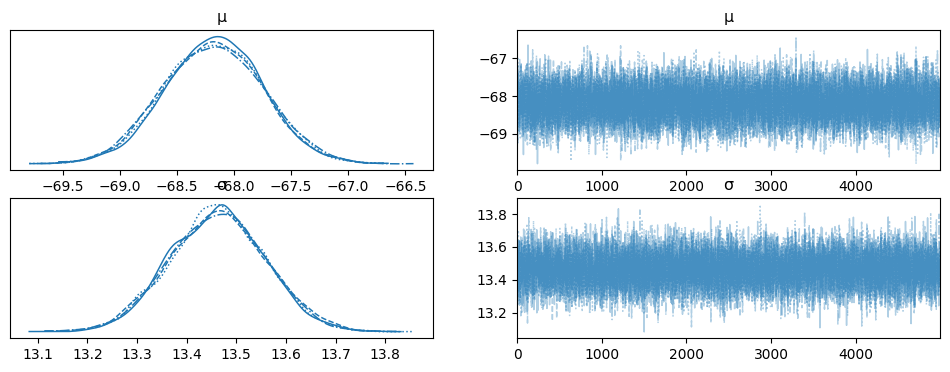

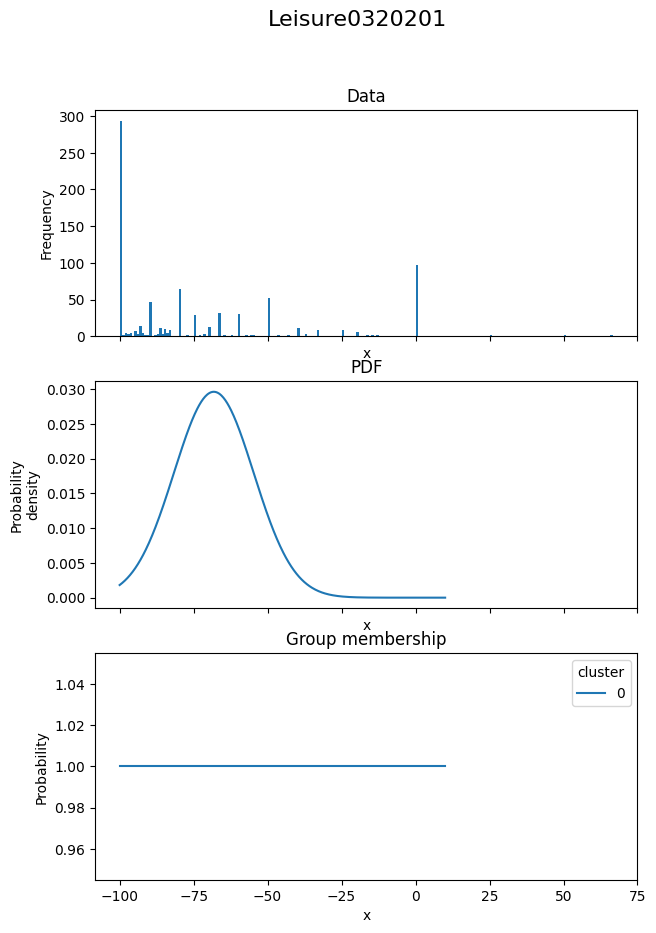